# Analyzing Airbnb Data

We'll start by importing relevant _libraries_ (i.e. prebuilt chunks of Python that have useful functions).

In [1]:
import pandas as pd    #data manipulation
import numpy as np     #mathematical operations

import matplotlib.pyplot as plt      #plotting tools

! pip install geopandas
import geopandas as gpd              #geo mapping tools

! pip install contextily==1.0.1
import contextily as ctx             #map illustrating tool

from urllib.request import urlopen   #web url reading
import json                          #json reader

     |████████████████████████████████| 1.0MB 7.5MB/s 
     |████████████████████████████████| 6.6MB 25.7MB/s 
     |████████████████████████████████| 15.4MB 181kB/s 
     |████████████████████████████████| 19.3MB 1.6MB/s 


We will downlaod data directly from from [Inside Airbnb](http://insideairbnb.com/get-the-data.html) as a pandas _dataframe_.

In [2]:
df = pd.read_csv("http://data.insideairbnb.com/united-states/ca/san-francisco/2021-04-07/visualisations/listings.csv")
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,958,"Bright, Modern Garden Unit - 1BR/1BTH",1169,Holly,NaN,Western Addition,37.770280,-122.433170,Entire home/apt,150,2,277,2021-04-05,1.94,1,112
1,5858,Creative Sanctuary,8904,NaN,NaN,Bernal Heights,37.744740,-122.420890,Entire home/apt,195,30,111,2017-08-06,0.76,1,365
2,7918,A Friendly Room - UCSF/USF - San Francisco,21994,Aaron,NaN,Haight Ashbury,37.765550,-122.452130,Private room,56,32,19,2020-03-06,0.13,8,365
3,8142,Friendly Room Apt. Style -UCSF/USF - San Franc...,21994,Aaron,NaN,Haight Ashbury,37.765550,-122.452130,Private room,56,32,8,2018-09-12,0.10,8,365
4,8339,Historic Alamo Square Victorian,24215,Rosy,NaN,Western Addition,37.775640,-122.436420,Entire home/apt,795,7,28,2019-06-28,0.20,2,364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6677,49061200,"Brand New, Modern 1 Bedroom in Pacific Heights",129904961,Galina,NaN,Pacific Heights,37.794186,-122.426405,Entire home/apt,135,30,0,NaN,NaN,3,259
6678,49062947,Junior Studio Room with Front Deck,203065170,Serhan,NaN,Noe Valley,37.749210,-122.430930,Private room,55,30,0,NaN,NaN,16,31
6679,49064041,Sunny Modern Top Floor Nob/Russian Hill 2BR,7239867,Brian,NaN,Nob Hill,37.791330,-122.419870,Entire home/apt,188,55,0,NaN,NaN,3,90
6680,49079039,Sunny Russian Hill Apt with Private Backyard &...,12850096,Benjamin,NaN,Russian Hill,37.799576,-122.422638,Entire home/apt,126,60,0,NaN,NaN,1,318


# Exploratory Data Analysis

We will use a for loop to see which columns are in this _dataframe_

In [3]:
for c in df.columns:
    print(c)

id
name
host_id
host_name
neighbourhood_group
neighbourhood
latitude
longitude
room_type
price
minimum_nights
number_of_reviews
last_review
reviews_per_month
calculated_host_listings_count
availability_365


We can count the entries in a given column using `df["<columns_name>"].value_counts()`.

In [4]:
host_listing_dict = df["host_id"].value_counts()

We can make a list of all hosts that have multiple listings.

In [5]:
pro_hosts = []

for k,v in host_listing_dict.items():
    if v > 1:
        pro_hosts.append(k)

Let's add a column to the dataframe indicating whether the listing belongs to a "pro host."

In [6]:
df["pro_host"] = np.nan

for i in df.index:
    top = df.loc[i,"host_id"] in pro_hosts
    df.loc[i,"pro_host"] = top

Are there other things you'd like to know?

# Preliminary Plotting

Choose plot colors from [Color Universal Design](https://jfly.uni-koeln.de/color/), by M. Okabe and K. Ito.

![universal_colors.png](https://github.com/annahaensch/DataAndSocialJustice/blob/main/Figures/universal_colors.png?raw=true)

In [8]:
colors = ["#E69F00","#56B4E9","#009E73","#F0E442","#0072B2","#D55E00","#CC79A7","#000000"]

We can make a bar chart of listings by room type.

In [9]:
room_type_dict = df["room_type"].value_counts().to_dict()

room_type_dict

{'Entire home/apt': 4145,
 'Hotel room': 95,
 'Private room': 2264,
 'Shared room': 178}

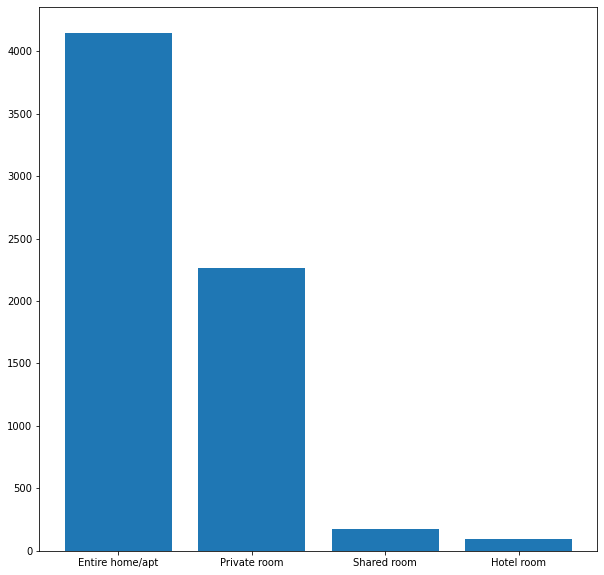

In [10]:
# Create lists for labels and counts.
labels = list(room_type_dict.keys())
listing_counts = list(room_type_dict.values())

# Initialize the figure and the axis.
fig, ax = plt.subplots(figsize = (10,10))

ax.bar(x = [1,2,3,4],height = listing_counts, tick_label = labels)

plt.show()

Let's see if we can refine this to understand something about listings by "pro hosts."  We can take a _slice_ of the dataframe based on a condition in a specific column with 
```
df[df["<column_name>"] <condition> ]
```
for example, 
```
df[df["neighbourhood"] == "Seacliff" ]

```
will restrict the dataframe to rows where the neighborhood is Seacliff. _Hint: `==` is a boolean meaning "is equal to."_

In [11]:
df_pro = df[df["pro_host"] == True]
pro_room_type_dict = df_pro["room_type"].value_counts().to_dict()

In [12]:
df_non = df[df["pro_host"] == False]
non_room_type_dict = df_non["room_type"].value_counts().to_dict()

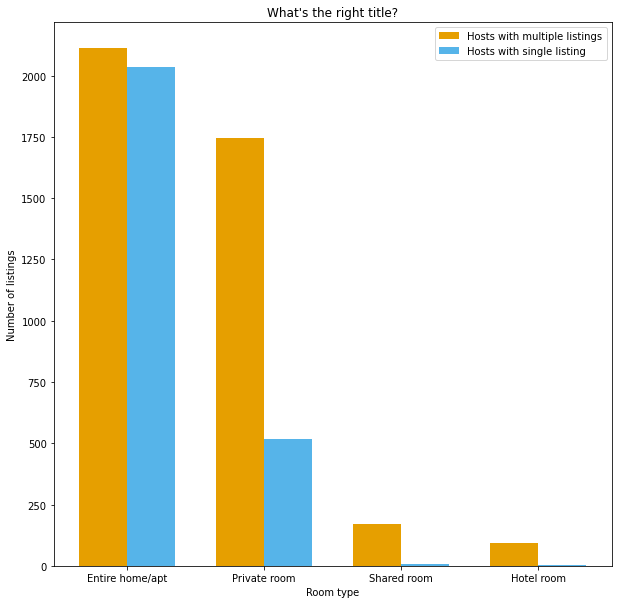

In [13]:
# Create lists for labels and counts.
labels = list(room_type_dict.keys())
pro_listing_counts = list(pro_room_type_dict.values())
non_listing_counts = list(non_room_type_dict.values())

x = np.arange(len(labels)) # The label locations
width = 0.35 # The width of the bars

# Initialize the figure and the axis.
fig, ax = plt.subplots(figsize = (10,10))

rects1 = ax.bar(x - width/2, pro_listing_counts, width, color = colors[0], label = "Hosts with multiple listings")
rects2 = ax.bar(x + width/2, non_listing_counts, width, color = colors[1], label = "Hosts with single listing")

# Add some annotation to the axes
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.set_xlabel("Room type")
ax.set_ylabel("Number of listings")

ax.legend()

ax.set_title("What's the right title?")

plt.show()

# Preliminary Mapping

We will start by getting the geometry of the neighborhood coordinates from Inside Airbnb.

In [15]:
url = "http://data.insideairbnb.com/united-states/ca/san-francisco/2021-04-07/visualisations/neighbourhoods.geojson"

#read geojson file from url
nbhd_df = gpd.read_file(url) 

#Project onto a flat crs for mapping.
nbhd_df = nbhd_df.to_crs(epsg=3857) 

nbhd_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Seacliff,None,"MULTIPOLYGON (((-13634866.418 4549507.782, -13..."
1,Haight Ashbury,None,"MULTIPOLYGON (((-13629509.167 4546849.811, -13..."
2,Outer Mission,None,"MULTIPOLYGON (((-13631548.540 4538288.971, -13..."
3,Downtown/Civic Center,None,"MULTIPOLYGON (((-13626497.752 4549820.778, -13..."
4,Diamond Heights,None,"MULTIPOLYGON (((-13629460.521 4542966.888, -13..."


Next we will get the geometry for the individual listings.

In [16]:
geo_df = gpd.GeoDataFrame(df[["latitude","longitude","pro_host"]], 
                                geometry=gpd.points_from_xy(df.longitude, df.latitude))

#Add spherical coordinate reference system (crs) to lat/long pairs.
geo_df.crs = "EPSG:4326" 

#Project onto a flat crs for mapping.
geo_df = geo_df.to_crs(epsg=3857) 

geo_df.head()

,latitude,longitude,pro_host,geometry
0,37.77028,-122.43317,False,POINT (-13629198.141 4547024.716)
1,37.74474,-122.42089,False,POINT (-13627831.137 4543428.629)
2,37.76555,-122.45213,True,POINT (-13631308.758 4546358.628)
3,37.76555,-122.45213,True,POINT (-13631308.758 4546358.628)
4,37.77564,-122.43642,True,POINT (-13629559.929 4547779.573)


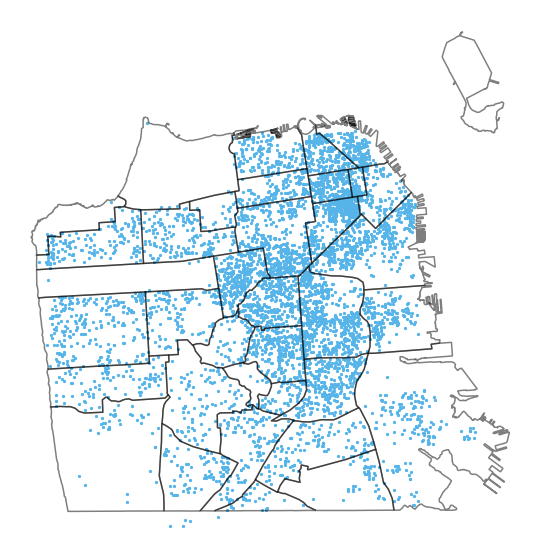

In [17]:
fig, ax = plt.subplots(figsize = (10,10))

# Plot neighborhood boundaries
nbhd_df.geometry.boundary.plot(ax = ax, alpha=0.5, edgecolor='k', color = 'k')

# Plot listings as points.
geo_df.plot(ax = ax, marker = "o", markersize = 5, color = colors[1])

# Add basemap behind geopandas plot.
# ctx.add_basemap(ax)

# Turn off axes
ax.set_axis_off()

plt.show()